## Módulos

In [ ]:
!pip install -q yfinance

In [ ]:
#Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

## Funções

In [ ]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)
  
  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except: 
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [ ]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS') 
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')    
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [ ]:
def melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe=''):  
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()
  
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')  
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]
  
  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  
  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]
  
  return melhores, piores

In [ ]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [ ]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

## Benckmarks

In [ ]:
cdi = cdi_acumulado('2023-01-01', '2023-05-25') * 100
cdi

,valor
data,
2023-01-02,100.000000
2023-01-03,100.101602
2023-01-04,100.152441
2023-01-05,100.203307
2023-01-06,100.254198
...,...
2023-05-18,104.888595
2023-05-19,104.941866
2023-05-22,104.995164


In [ ]:
ibov = yf.download('^BVSP', start='2023-01-01', end='2023-05-26')['Close']
ibov = (ibov / ibov.iloc[0])*100

[*********************100%***********************]  1 of 1 completed


## Buscando Dados da CVM

In [ ]:
cadastro = busca_cadastro_cvm()
cadastro

<ipython-input-3-3c912d81f294>:7: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(url, sep=';', encoding='ISO-8859-1')


,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR,INVEST_CEMPR_EXTER
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCEIRO - MAX,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INVESTIMENTO,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC 60 DIAS URV,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIMENTO FINANCEIRO,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72399,FUNCINE,28.850.140/0001-78,FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE - TIM,2017-10-16,2017-10-06,417001.0,NaN,EM FUNCIONAMENTO NORMAL,2017-12-26,2017-12-26,...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN
72400,FUNCINE,28.912.043/0001-62,HAPVIDA - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE,2017-10-27,2017-10-19,417003.0,NaN,EM FUNCIONAMENTO NORMAL,2018-12-21,2018-12-21,...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN
72401,FUNCINE,31.674.280/0001-47,MEDIA VENTURE ESG INCENTIVADO - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL,2018-10-26,2018-09-13,418001.0,NaN,EM FUNCIONAMENTO NORMAL,2022-12-26,2022-12-26,...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,16.549.480/0001-84,RSM BRASIL AUDITORES INDEPENDENTES - SOCIEDADE SIMPLES,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN
72402,FUNCINE,32.222.962/0001-81,Fundo de Financiamento da Indústria Cinematográfica Nacional de Minas Gerais,2018-12-20,2018-11-14,418002.0,2021-10-29,CANCELADA,2021-10-29,NaN,...,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES LTDA.,15.489.568/0001-95,INTRA INVESTIMENTOS DTVM LTDA,NaN,NaN,NaN


In [ ]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2023-01', data_fim='2023-04')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2023-01-02,1101835.91,30.974427,1104834.84,0.0,0.0,1
1,FI,00.017.024/0001-53,2023-01-03,1102410.18,30.988913,1105351.56,0.0,0.0,1
2,FI,00.017.024/0001-53,2023-01-04,1102994.24,31.003303,1105864.82,0.0,0.0,1
3,FI,00.017.024/0001-53,2023-01-05,1103561.75,31.017294,1106363.87,0.0,0.0,1
4,FI,00.017.024/0001-53,2023-01-06,1103794.86,31.030820,1106846.36,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
2002844,FI,97.929.213/0001-34,2023-04-24,80199237.86,10.552686,80193249.26,0.0,0.0,2
2002845,FI,97.929.213/0001-34,2023-04-25,80243257.61,10.558412,80236765.37,0.0,0.0,2
2002846,FI,97.929.213/0001-34,2023-04-26,80291594.80,10.564706,80284598.69,0.0,0.0,2
2002847,FI,97.929.213/0001-34,2023-04-27,80340700.70,10.571102,80333200.49,0.0,0.0,2


#FUNDOS MULTIMERCADO

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='multimercado')


<ipython-input-5-486ba0872cea>:6: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')


In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
36.673.471/0001-08,63.418111,QR BTC MAX FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO INVEST NO EXTERIOR,Fundo Multimercado,0.000000e+00
36.986.672/0001-65,62.980921,HASHDEX BITCOIN FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.212792e+08
41.771.697/0001-81,61.809548,BTG PACTUAL REFERENCE BITCOIN 100 FI COTAS FI MULTIMERCADO INVESTIMENTO NO EXTERIOR,Fundo Multimercado,6.395915e+06
33.736.845/0001-07,57.099686,HASHDEX 100 NASDAQ CRYPTO INDEX FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.014691e+08
43.105.341/0001-34,56.981308,TREND CRIPTO DÓLAR FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.029418e+07


## Fundos de Ações

In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='acoes')

<ipython-input-5-486ba0872cea>:6: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')


In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
36.249.317/0001-03,32.282554,ITAÚ INDEX US TECH FICFI EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,3.341999e+08
29.152.427/0001-97,32.123144,ITAÚ US TECH FUNDO DE INVEST EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,7.580132e+07
30.068.271/0001-40,32.053445,CAIXA FUNDO DE INVESTIMENTO EM AÇÕES BANCO DO BRASIL PLUS,Fundo de Ações,6.957478e+07
09.134.614/0001-30,31.944829,BB AÇÕES BB FUNDO DE INVESTIMENTO,Fundo de Ações,3.877625e+08
13.199.100/0001-30,28.516336,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,Fundo de Ações,5.000652e+06


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
37.396.790/0001-86,-29.768712,TREND HPX SPAC FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,15734867.26
34.218.661/0001-00,-28.542789,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,21407449.18
31.188.723/0001-90,-27.110513,ULTRA PERFORMANCE CTM FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,Fundo de Ações,47957643.33
18.558.694/0001-42,-21.209850,CTM ESTRATEGIA FUNDO DE INVESTIMENTO EM AÇÕES - BDR NIVEL I,Fundo de Ações,63307836.38
07.470.234/0001-41,-17.855180,SAFRA VALE DO RIO DOCE - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES,Fundo de Ações,43080888.87


### Graficos

In [ ]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,ITAÚ INDEX US TECH FICFI EM AÇÕES INVESTIMENTO NO EXTERIOR,ITAÚ US TECH FUNDO DE INVEST EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,CAIXA FUNDO DE INVESTIMENTO EM AÇÕES BANCO DO BRASIL PLUS,BB AÇÕES BB FUNDO DE INVESTIMENTO,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,TREND HPX SPAC FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,ULTRA PERFORMANCE CTM FUNDO DE INVESTIMENTO EM AÇÕES - BDR NÍVEL I,CTM ESTRATEGIA FUNDO DE INVESTIMENTO EM AÇÕES - BDR NIVEL I,SAFRA VALE DO RIO DOCE - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES
2023-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-01-03,98.779410,98.784649,98.131855,98.154974,98.082849,101.546309,99.782693,101.336319,99.996955,99.809746
2023-01-04,99.409244,99.412030,99.387598,99.395508,98.463429,101.692547,103.361255,100.779673,99.481687,99.975078
2023-01-05,97.352429,97.363694,103.900331,103.864383,102.676557,100.082586,102.013222,101.525246,100.001017,101.624702
2023-01-06,99.715308,99.719349,105.330940,105.284415,106.506403,97.870517,99.087781,100.926002,100.006321,103.207890
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,128.596271,128.451770,133.805714,133.694226,130.440261,69.072398,69.546070,72.510312,76.638781,81.692488
2023-04-25,125.598892,125.465556,132.569121,132.458738,126.228934,71.469245,68.356783,72.143913,76.181234,79.464138
2023-04-26,127.342782,127.202743,131.484506,131.377183,119.721666,68.350378,68.302478,71.118574,75.311888,79.759675
2023-04-27,131.485295,131.328978,131.630499,131.523027,123.163786,69.481704,71.607276,72.041225,77.388901,81.432455


In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos Cambial


In [ ]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='cambial')

<ipython-input-5-486ba0872cea>:6: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



In [ ]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
32.246.789/0001-51,13.275824,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,19034749.23
32.471.624/0001-83,13.016607,BV USD SHORT CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,6261631.36
04.305.193/0001-40,-3.035684,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,76075418.31
37.569.678/0001-08,-4.732375,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,14692881.19
32.745.560/0001-61,-5.032123,ICATU VANGUARDA DÓLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,2508664.47


In [ ]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
00.819.855/0001-49,-6.330791,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,Fundo Cambial,8.480693e+05
01.171.956/0001-19,-6.102946,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,Fundo Cambial,5.083889e+06
04.128.893/0001-06,-5.690286,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,2.641035e+08
04.061.044/0001-82,-5.632957,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,4.852745e+08
05.222.509/0001-00,-5.620569,BRADESCO PRIME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,Fundo Cambial,2.473897e+07


### Grafico de Cotas

In [ ]:
cotas = pd.DataFrame()
fundos_destaque =  pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [ ]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BV USD SHORT CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,ICATU VANGUARDA DÓLAR FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BRADESCO PRIME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR
2023-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-01-03,98.425572,98.417626,99.452190,101.009267,101.653285,101.884016,101.674874,101.646560,101.647359,101.684138
2023-01-04,98.537372,98.502265,101.341751,101.145263,101.653383,101.578255,101.660820,101.636232,101.637794,101.676914
2023-01-05,100.068889,100.029036,99.829663,98.722267,100.205201,100.143994,100.166851,100.184245,100.186563,100.187315
2023-01-06,102.381918,102.351693,98.450155,97.546947,98.047496,97.986659,97.920935,97.985251,97.988281,97.944145
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,111.816676,111.584611,97.970554,96.550714,95.843882,94.616259,94.847692,95.219097,95.274028,95.310733
2023-04-25,111.258561,111.027055,97.621627,96.816476,96.388532,95.146924,95.401835,95.798012,95.854024,95.874762
2023-04-26,111.591404,111.365185,98.217000,96.874657,96.195026,94.927451,95.188503,95.597465,95.654093,95.665877
2023-04-27,113.442902,113.187456,96.846932,95.309740,94.748286,93.463672,93.682223,94.094040,94.150535,94.155575


In [ ]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BV USD SHORT CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,ICATU VANGUARDA DÓLAR FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BRADESCO PRIME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR
2023-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-01-03,98.425572,98.417626,99.452190,101.009267,101.653285,101.884016,101.674874,101.646560,101.647359,101.684138
2023-01-04,98.537372,98.502265,101.341751,101.145263,101.653383,101.578255,101.660820,101.636232,101.637794,101.676914
2023-01-05,100.068889,100.029036,99.829663,98.722267,100.205201,100.143994,100.166851,100.184245,100.186563,100.187315
2023-01-06,102.381918,102.351693,98.450155,97.546947,98.047496,97.986659,97.920935,97.985251,97.988281,97.944145
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,111.816676,111.584611,97.970554,96.550714,95.843882,94.616259,94.847692,95.219097,95.274028,95.310733
2023-04-25,111.258561,111.027055,97.621627,96.816476,96.388532,95.146924,95.401835,95.798012,95.854024,95.874762
2023-04-26,111.591404,111.365185,98.217000,96.874657,96.195026,94.927451,95.188503,95.597465,95.654093,95.665877
2023-04-27,113.442902,113.187456,96.846932,95.309740,94.748286,93.463672,93.682223,94.094040,94.150535,94.155575


In [ ]:
ibov

Date
2023-01-02    100.000000
2023-01-03     97.922464
2023-01-04     99.020456
2023-01-05    101.073550
2023-01-06    102.312552
                 ...    
2023-05-19    104.107129
2023-05-22    103.607017
2023-05-23    103.340039
2023-05-24    102.278709
2023-05-25    103.457547
Name: Close, Length: 99, dtype: float64

In [ ]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos Cambiais do 1º Semestre de 2023')
fig.update_layout(legend_orientation="h")

fig.show()

In [ ]:
cotas.columns

Index(['TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'BV USD SHORT CAMBIAL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL',
       'ICATU VANGUARDA DÓLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL',
       'BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR',
       'BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BRADESCO PRIME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR'],
      dtype='object', name='Fundo de Investimento')

### Correlação

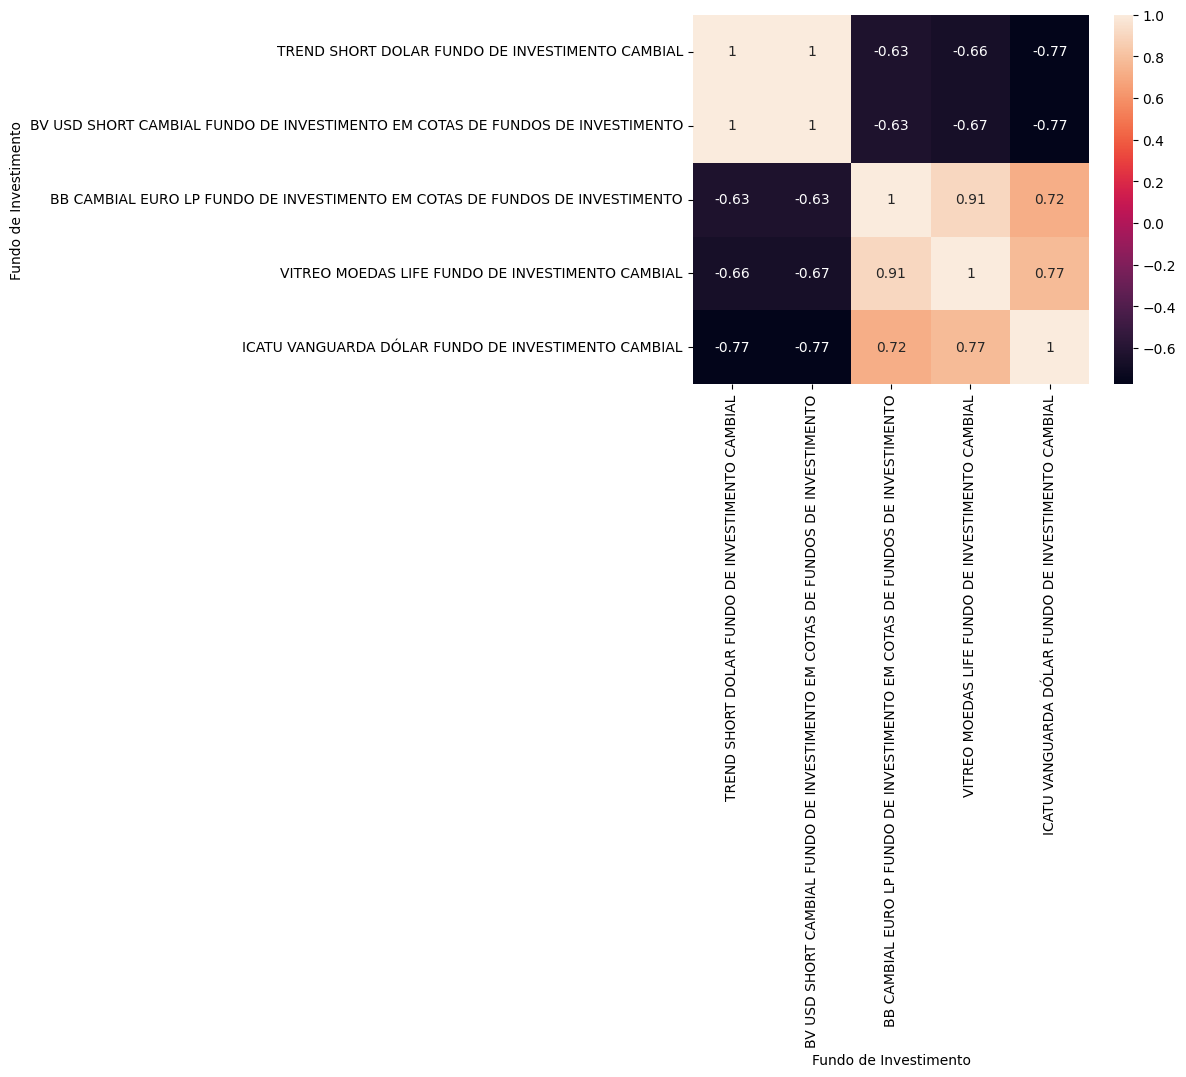

In [ ]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

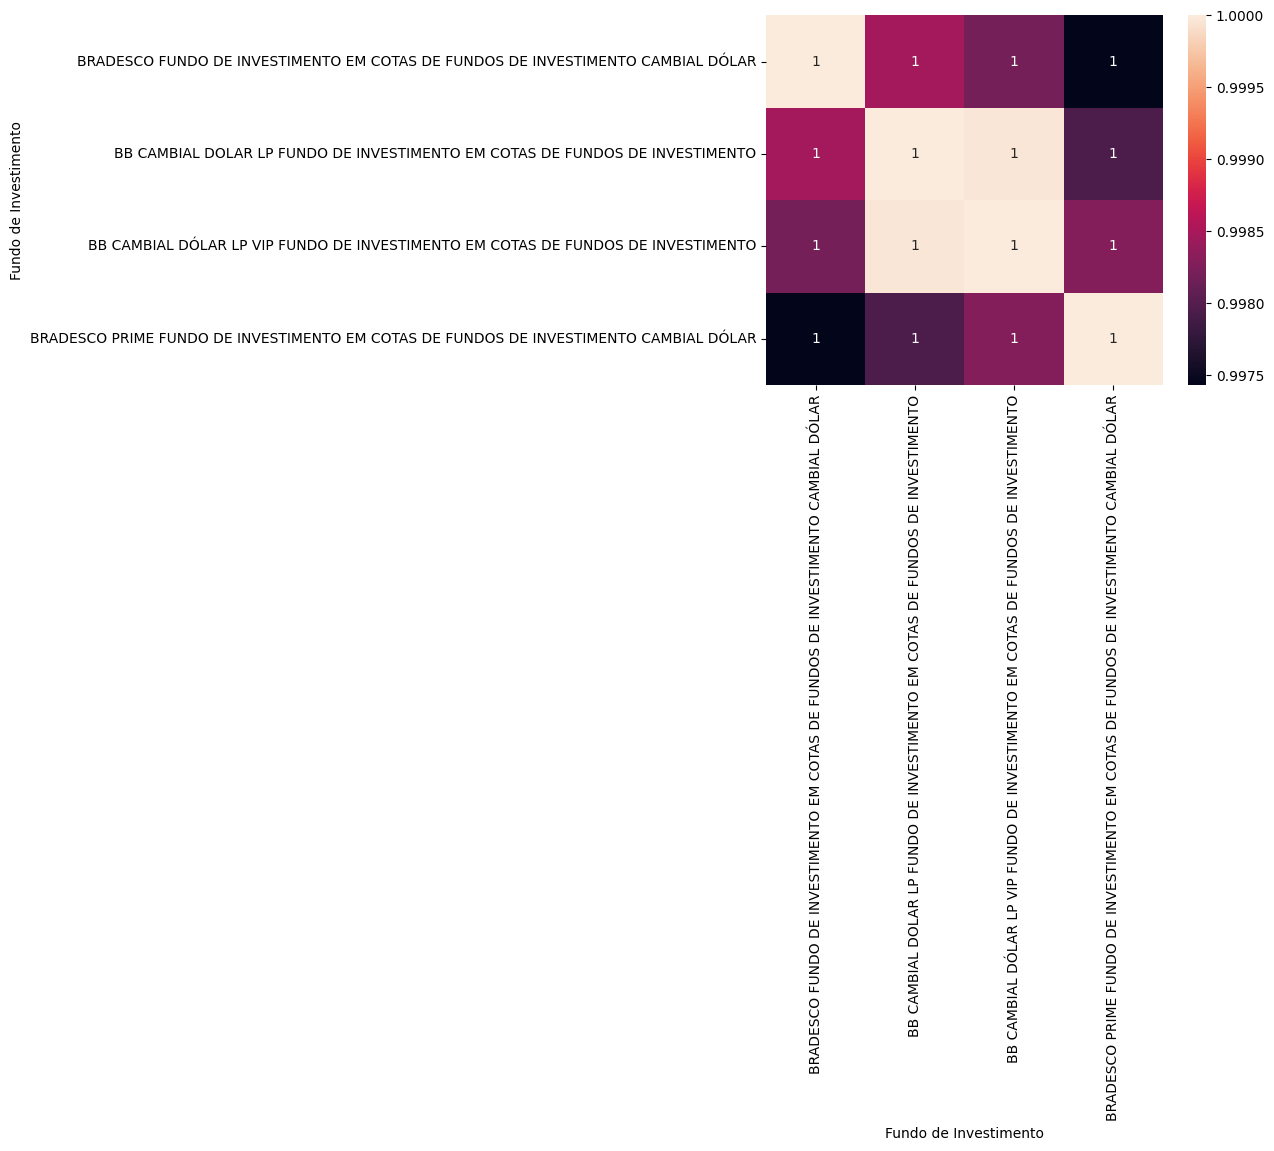

In [ ]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);